In [ ]:
import tensorflow as tf2
print(tf2.__version__)

import random
import numpy as np
from numpy import cos,sin,tan
import matplotlib.pyplot as plt

In [ ]:
gpus = tf2.config.list_logical_devices('GPU')
print(gpus)

In [ ]:
tf2.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf2.config.list_physical_devices('GPU')))


In [12]:
# states : [x,y,z,r,p,y,vx,vy,vz,wx,wy,wz]
# inputs : [F,tx,ty,tz]
def quad_model(state):
  # x.reshape(-1,1)
  g  = 9.81
  m  = 0.468
  L  = 0.225
  km = 20
  kF = 2.980*10**(-6)
  kM = 1.140*10**(-7)
  IM = 3.357*10**(-5)
  Ixx = 4.856*10**(-3)
  Iyy = 4.856*10**(-3)
  Izz = 8.801*10**(-3)
  Ax = 0.25
  Ay = 0.25
  Az = 0.25

  x       = state[0]
  y       = state[1]
  z       = state[2]
  vx      = state[3]
  vy      = state[4]
  vz      = state[5]
  phi     = state[6]
  theta   = state[7]
  psi     = state[8]
  p       = state[9]
  q       = state[10]
  r       = state[11]
  T  = state[12]
  Tx  = state[13]
  Ty  = state[14]
  Tz  = state[15]
  Gamma  = state[16]

  Position     = np.array([[x],[y],[z]])
  Velocity     = np.array([[vx],[vy],[vz]])
  Angle        = np.array([[phi],[theta],[psi]])
  AngularVel   = np.array([[p],[q],[r]])
  Tau = np.array([[Tx],[Ty],[Tz]])
  
  e3 = np.array([[0],[0],[1]])
  I = np.array([[Ixx,0,0],[0,Iyy,0],[0,0,Izz]])
  A = np.array([[Ax,0,0],[0,Ay,0],[0,0,Az]])

  W = np.array([[1, sin(phi)*tan(theta), cos(phi)*tan(theta)],
                [0, cos(phi), -sin(phi)],
                [0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])

  R = np.array([[cos(psi)*sin(theta)*cos(phi)+sin(psi)*sin(phi)],
                [sin(psi)*sin(theta)*cos(phi)-cos(psi)*sin(phi)],
                [cos(theta)*cos(phi)]])
  
  P1 = np.array([[(Iyy-Izz)*q*r/Ixx],
                 [(Izz-Ixx)*p*r/Iyy],
                 [(Ixx-Iyy)*p*q/Izz]])
  
  P2 = np.array([[IM*q/Ixx*Gamma],
                 [IM*(-p)/Iyy*Gamma],
                 [0]])
  
  P3 = np.array([[Tau[0][0]/Ixx],
                 [Tau[1][0]/Iyy],
                 [Tau[2][0]/Izz]])
  
  x_dot = Velocity
  v_dot = -g*e3 + T/m*R - 1/m*np.matmul(A,Velocity)
  r_dot = np.matmul(W,AngularVel)
  w_dot = P1-P2+P3

  return np.concatenate((x_dot.T,v_dot.T,r_dot.T,w_dot.T),axis=1)
  # return np.concatenate((v_dot.T, w_dot.T),axis=1);
  # return np.array(v_dot.T)

In [ ]:
list_Size = 10000
L  = 0.225
km = 20
kF = 2.980*10**(-6)
kM = 1.140*10**(-7)
def get_x_train(list_Size):
  p = np.array([10.0,10.0,10.0,3.14/3,3.14/3,3.14,10.0,10.0,10.0,10.0,10.0,10.0,25.0,1.0,1.0,1.0])
  x_train12 = (np.random.randint(2000,size=(list_Size,2))-1000)/100
  x_train3 = (np.random.randint(2000,size=(list_Size,1))-1000)/100
  x_train46 = (np.random.randint(2000,size=(list_Size,3))-1000)/100
  
  x_train7 = (np.random.randint(628/4,size=(list_Size,1))-314/4)/100
  x_train8 = (np.random.randint(628/4,size=(list_Size,1))-314/4)/100
  x_train9 = (np.random.randint(628,size=(list_Size,1))-314)/100
  x_train1012 = (np.random.randint(200,size=(list_Size,3))-100)/100
  x_train1316 = (np.random.randint(90000,size=(list_Size,4)))/100
  # x_train1416 = (np.random.randint(90000,size=(list_Size,3)))/100

  F = kF*x_train1316**2
  M = kM*x_train1316**2
  # F = kF*np.array([[sigma1**2],[sigma2**2],[sigma3**2],[sigma4**2]])
  # M = kM*np.array([[sigma1**2],[sigma2**2],[sigma3**2],[sigma4**2]])
  
  T = np.sum(F,axis=1)
  T = T.reshape(-1,1)

  Tx = L*(-F[:,1]+F[:,3])
  Ty = L*(-F[:,0]+F[:,2])
  Tz = -M[:,0]+M[:,1]-M[:,2]+M[:,3]
  Tx = Tx.reshape(-1,1)
  Ty = Ty.reshape(-1,1)
  Tz = Tz.reshape(-1,1)

  Gamma = x_train1316[:,0] - x_train1316[:,1] + x_train1316[:,2] - x_train1316[:,3]
  Gamma = Gamma.reshape(-1,1)

  xtrain = np.column_stack((x_train12,x_train3,x_train46,x_train7,x_train8,x_train9,x_train1012,T,Tx,Ty,Tz,Gamma))
  xtrain2 = np.column_stack((x_train12,x_train3,x_train46,x_train7,x_train8,x_train9,x_train1012,T,Tx,Ty,Tz,Gamma))
  
  return xtrain, xtrain2

x_train,x_train2 = get_x_train(list_Size)
print(x_train[0])
# x_train = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
y_train = quad_model(x_train[0])

for i in range(1,len(x_train)):
  y = quad_model(x_train[i])
  y_train = np.vstack((y_train,y))
print(y_train[0],x_train.shape)

In [14]:
list_Size = 10000
L  = 0.225
km = 20
kF = 2.980*10**(-6)
kM = 1.140*10**(-7)
def get_x_val(list_Size):
  p = np.array([10.0,10.0,10.0,3.14/3,3.14/3,3.14,10.0,10.0,10.0,10.0,10.0,10.0,25.0,1.0,1.0,1.0])
  x_train12 = (np.random.randint(20000,size=(list_Size,2))-10000)/100
  x_train3 = (np.random.randint(20000,size=(list_Size,1))-10000)/100
  x_train46 = (np.random.randint(20000,size=(list_Size,3))-10000)/100
  
  x_train7 = (np.random.randint(628/4,size=(list_Size,1))-314/4)/100
  x_train8 = (np.random.randint(628/4,size=(list_Size,1))-314/4)/100
  x_train9 = (np.random.randint(628,size=(list_Size,1))-314)/100
  x_train1012 = (np.random.randint(400,size=(list_Size,3))-200)/100
  x_train1316 = (np.random.randint(90000,size=(list_Size,4)))/100
  # x_train1416 = (np.random.randint(90000,size=(list_Size,3)))/100

  F = kF*x_train1316**2
  M = kM*x_train1316**2
  # F = kF*np.array([[sigma1**2],[sigma2**2],[sigma3**2],[sigma4**2]])
  # M = kM*np.array([[sigma1**2],[sigma2**2],[sigma3**2],[sigma4**2]])
  
  T = np.sum(F,axis=1)
  T = T.reshape(-1,1)

  Tx = L*(-F[:,1]+F[:,3])
  Ty = L*(-F[:,0]+F[:,2])
  Tz = -M[:,0]+M[:,1]-M[:,2]+M[:,3]
  Tx = Tx.reshape(-1,1)
  Ty = Ty.reshape(-1,1)
  Tz = Tz.reshape(-1,1)

  Gamma = x_train1316[:,0] - x_train1316[:,1] + x_train1316[:,2] - x_train1316[:,3]
  Gamma = Gamma.reshape(-1,1)

  xtrain = np.column_stack((x_train12,x_train3,x_train46,x_train7,x_train8,x_train9,x_train1012,T,Tx,Ty,Tz,Gamma))
  xtrain2 = np.column_stack((x_train12,x_train3,x_train46,x_train7,x_train8,x_train9,x_train1012,T,Tx,Ty,Tz,Gamma))
  
  return xtrain, xtrain2

In [ ]:
x_eval,x_eval2 = get_x_train(1000)
y_eval = quad_model(x_eval[0])
for i in range(1,len(x_eval)):
  y = quad_model(x_eval[i])
  y_eval = np.vstack((y_eval,y))
print(x_eval[0])
print(x_eval2[0])
print(y_eval,y_eval.shape)

In [ ]:
model = tf2.keras.Sequential([
    tf2.keras.Input(shape=(17,), name="input"),
    # tf2.keras.layers.Dense(units=512, activation='relu', name="layer1"),
    # tf2.keras.layers.Dense(units=512, activation='relu', name="layer2"),
    tf2.keras.layers.Dense(units=64, activation='relu', name="layer3"),
    tf2.keras.layers.Dense(units=64, activation='relu', name="layer4"),
    tf2.keras.layers.Dense(units=12, name="output")
])

In [ ]:
epochs = 1000
batch_size = 64
initial_learning_rate = 0.001
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(len(x_train2)/batch_size)

lr_schedule = tf2.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor)

# checkpoint_dir = "./train_lbcr5/cp-{epoch:04d}.ckpt"

# cp_callback = tf2.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_dir, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5000*batch_size)

# model.compile(optimizer=tf2.keras.optimizers.legacy.Adam(learning_rate=lr_schedule), 
#               loss='mae',
#               metrics=['mse'])

model.compile(optimizer=tf2.keras.optimizers.legacy.RMSprop(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae'])

In [ ]:
x_train,x_train2 = get_x_train(list_Size)

y_train = quad_model(x_train[0])
for i in range(1,len(x_train)):
  y = quad_model(x_train[i])
  y_train = np.vstack((y_train,y))

x_train2 = tf2.convert_to_tensor(x_train2, dtype=tf2.float32)
y_train = tf2.convert_to_tensor(y_train, dtype=tf2.float32)


In [ ]:
with tf2.device('/device:GPU:0'):
  hist = model.fit( x_train2, y_train, epochs = epochs,callbacks=[],batch_size=batch_size,verbose=2)

In [ ]:
x_eval,x_eval2 = get_x_train(10000)
y_eval = quad_model(x_eval[0])
for i in range(1,len(x_eval)):
  y = quad_model(x_eval[i])
  y_eval = np.vstack((y_eval,y))
model.evaluate(x_eval2,y_eval)

In [ ]:
# x_eval = np.array([0,0,0,0.,0.,0.,0,0,0.0,0,0,0,8,0,0,0]).T;
# x_eval2 = np.array([0,0,0,0.,0.,0.,0,0,0.0,0,0,0,8,0,0,0]).T;
# # x_eval2 = np.array([0,0,0,np.cos(0.),np.sin(0.),np.cos(0.),np.sin(0.),np.cos(0),np.sin(0),0,0,0,0,0,0,20.0/25.0,0,0,0]).T;
# y_eval = quad_model(x_eval)
# y_pre = model.predict([list(x_eval)])
# print(x_eval)
# print(y_eval[0])
# print(y_pre[0])

In [ ]:
x_eval,x_eval2 = get_x_train(100)
y_eval = quad_model(x_eval[0])
y_pre = model.predict([list(x_eval[0,:])])
for i in range(1,len(x_eval2)):
  y = quad_model(x_eval[i])
  y_eval = np.vstack((y_eval,y))
  y_pre = np.vstack((y_pre,model.predict([list(x_eval2[i,:])])))
print(x_eval2[0])
print(y_eval[0])
print(y_pre[0])

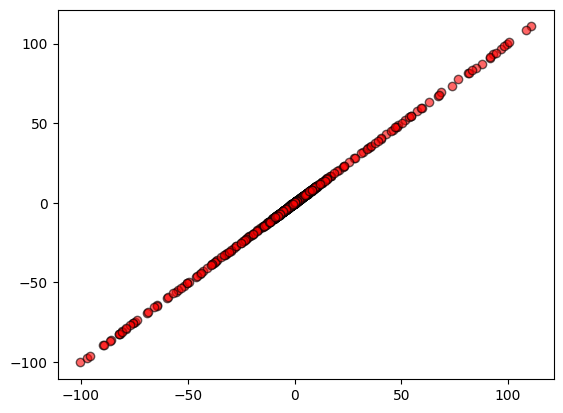

In [20]:
plt.scatter(y_eval, y_pre, alpha=0.6, color='#FF0000', lw=1, ec='black')

In [ ]:
latest = tf2.train.latest_checkpoint("./train_lbcr5/")
model.load_weights(latest)

In [ ]:
print(len(x_eval))
for i in range(1000):
  y = tflite_model.predict_single(x_eval2[0])
start_time = time.time()
y = tflite_model.predict_single(x_eval2[0])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
y = kmodel.predict([list(x_eval2[0])])
print("--- %s seconds ---" % (time.time() - start_time))
print(len(y))

In [ ]:
x_eval,x_eval2 = get_x_train(2)
x_eval = np.array([0.57,0.53,0.51,-1.12,-1.42,-1.44,-0.88,-0.7,-0.26,-0.56,-0.73,-1.62,15.17,0.41,-0.89,0.19]).T;
x_eval2 = np.array([0.57,0.53,0.51,np.cos(-1.12),np.sin(-1.12),np.cos(-1.42),np.sin(-1.42),np.cos(-1.44),np.sin(-1.44),-0.88,-0.7,-0.26,-0.56,-0.73,-1.62,15.17,0.41,-0.89,0.19]).T;
x_eval.reshape(-1,1)
x_eval[12]

15.17

In [ ]:
model.save('/home/mohit/lbcfr_colab/model_0405_11_2_lr')

INFO:tensorflow:Assets written to: /home/mohit/lbcfr_colab/model_0405_11_2_lr/assets


In [16]:
model = tf2.keras.models.load_model('/home/mohit/lbcfr_colab/model_0405_8_lr')

In [ ]:
model.save('/home/mohit/lbcfr_colab/model_0405_11_lite')

INFO:tensorflow:Assets written to: /home/mohit/lbcfr_colab/model_0405_11_lite/assets


INFO:tensorflow:Assets written to: /home/mohit/lbcfr_colab/model_0405_11_lite/assets
